<a href="https://colab.research.google.com/github/AndriyBabiy/goit_deep-learning/blob/main/01_PyTorch_Fundamentals/01_PyTorch_Fundementals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 - Pytorch Basics

This project is focued on utilising neural networks in order to predict which factors impact the strength of concrete.

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

## Import Libraries and Data

In [79]:
from google.colab import drive
drive.mount('/content/drive/')

path_to_file = '/content/drive/MyDrive/GoIT_Neoversity/deep_learning/'

df = pd.read_csv(path_to_file + 'ConcreteStrengthData.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [80]:
df.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


## Exploratory Data Analysis

In [81]:
df.describe()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


Based on the outline provided by the describe method it is evident that there are no missing values as all of the rows have similar amounts of datapoints. However, one thing that is noticable is that there are outliers in some of the rows as the maximum of the row seems to be greater than 3SD's above the mean.

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
 8   Strength                   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Based on the above information it is also evident that the data is mainly of the numerical type.

In [83]:
target = 'Strength'
features = [col for col in df.columns if col != target]

print(f'Number of features: {len(features)}')
print('Features:', features)

Number of features: 8
Features: ['CementComponent ', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']


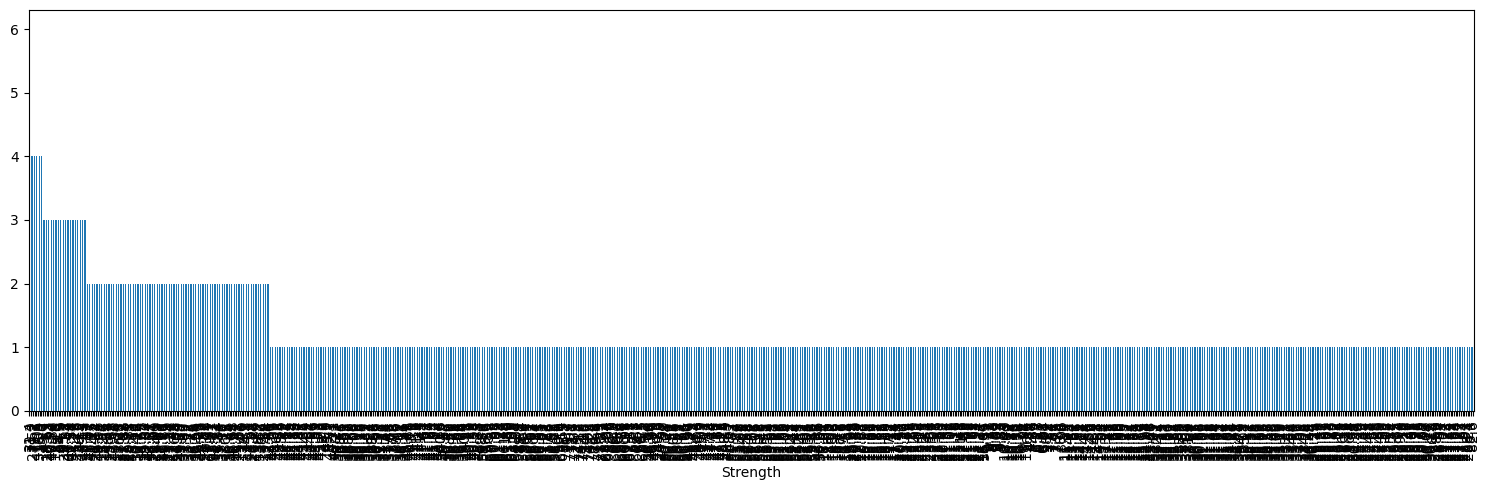

In [84]:
ax = df[target].sort_values().value_counts().plot(kind='bar', figsize=(15,5))

plt.tight_layout()
plt.show()

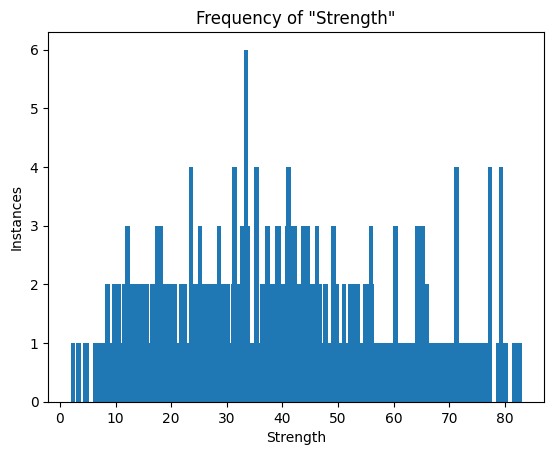

In [85]:
from collections import Counter

def target_dist(data_points):
  counter = Counter(data_points)

  sorted_data = sorted(counter.items())

  x_values, y_counts = zip(*sorted_data)

  plt.bar(x_values, y_counts)

  plt.xlabel(target)
  plt.ylabel('Instances')
  plt.title(f'Frequency of "Strength"')

  plt.show()

target_dist(df[target])

Based on the distribution of the target values it seems that there is a pattern of the strength distribution and that almost every value is unique, however there are some values that are seen more than once.

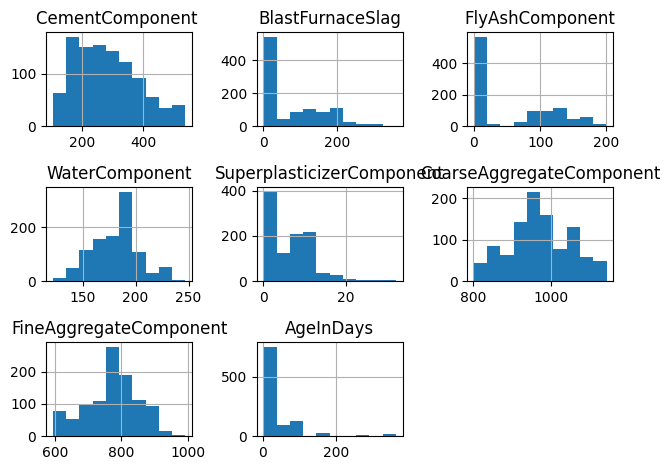

In [86]:
ax = df.loc[:, features].hist()

plt.tight_layout()
plt.show()

## Preparing the data for training

### Removing the outliers that have a z-score of over 3

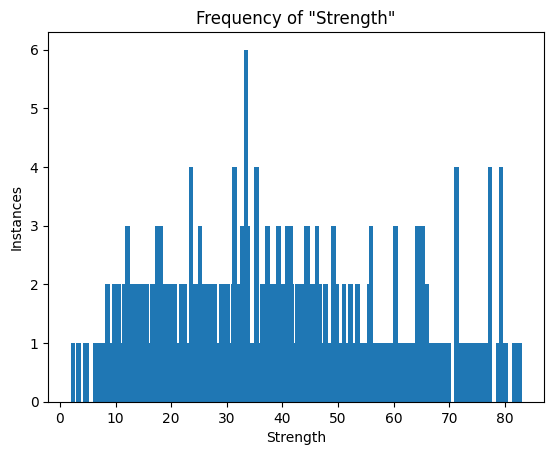

In [87]:
from scipy.stats import zscore
import numpy as np

df_z_score= zscore(df, nan_policy='omit')
df_out = np.abs(df_z_score).ge(3).astype(int).mean(1)

out_indexes = df_out[df_out > 0].index

df_clean = df.drop(index=out_indexes)

target_dist(df_clean[target])

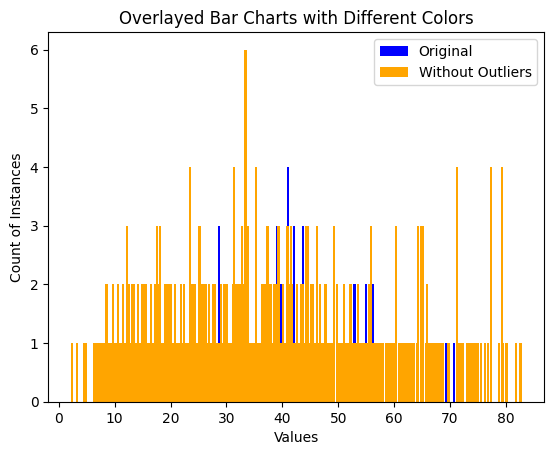

In [92]:
# Count the frequency of each value for both datasets
counter_1 = Counter(df[target])
counter_2 = Counter(df_clean[target])

# Sort the data based on the x-axis (values)
sorted_data_1 = sorted(counter_1.items())  # List of tuples (value, count)
sorted_data_2 = sorted(counter_2.items())  # List of tuples (value, count)

# Unpack the sorted values and counts
x_values_1, y_counts_1 = zip(*sorted_data_1)
x_values_2, y_counts_2 = zip(*sorted_data_2)

# Plotting the first dataset
plt.bar(x_values_1, y_counts_1, width=0.4, color='blue', align='center', label='Original')

# Plotting the second dataset with a slight shift on the x-axis for better visibility
plt.bar([x for x in x_values_2], y_counts_2, width=0.4, color='orange', align='center', label='Without Outliers')

# Adding labels, legend, and title
plt.xlabel('Values')
plt.ylabel('Count of Instances')
plt.title('Overlayed Bar Charts with Different Colors')
plt.legend()

# Display the plot
plt.show()

### Checking for covariance between the features

<Axes: >

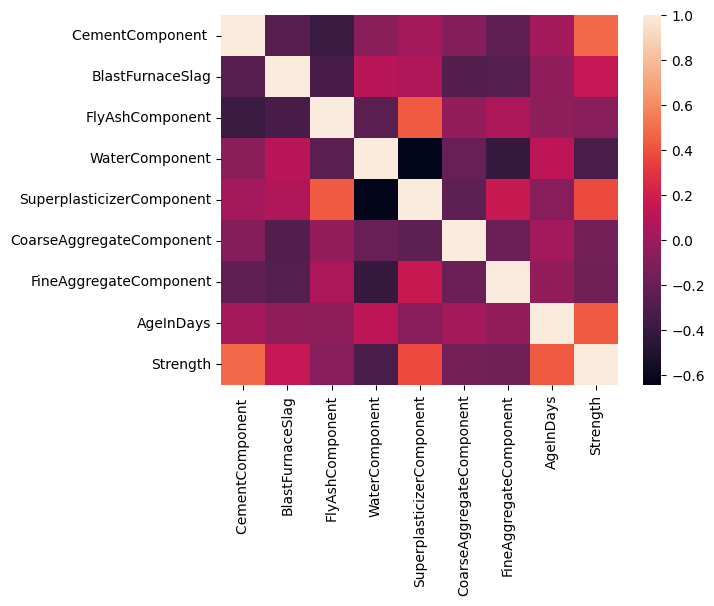

In [93]:
# =============================================================================
# Setting the df value
# =============================================================================
df = df_clean

import seaborn as sns

corr_matrix = df.corr()

sns.heatmap(corr_matrix)

## Creating and Training the neural network to predict concrete strength

## Analyse the model performance

## Conclusion and analysis of the results